# Wasserstein Distance for Gaussian Densities

This Notebook accompanies Chapter 6, specifically section 6.1 (Elliptic Shapes).

Here, visualizations of the Gauss-Wasserstein distance between elliptic object extents and comparison to the naive squared euclidean distance are shown.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from scipy.linalg import sqrtm
from matplotlib import animation
matplotlib.rcParams['animation.html'] = 'html5'

First, the distance functions for Gauss-Wasserstein and euclidean distances are defined.

In [2]:
def gwd_shape(d1, X1, d2, X2):
    """
    Squared Gaussian Wasserstein Distance as defined in eq. (63)
    Compares two elliptic extended targets defined by their centers (d) and shape matrices (X)
    """
    d1, X1, d2, X2 = np.array(d1), np.array(X1), np.array(d2), np.array(X2)
    # first: perform preliminary calculations
    X1sqrt = sqrtm(X1)
    C = sqrtm(X1sqrt @ X2 @ X1sqrt)
    
    # finally: construct GW distance
    d = np.linalg.norm(d1-d2)  
    d += np.trace(X1 + X2 - 2*C)
    # for sgw == 0, rounding errors might cause a minimally negative result. round to avoid
    if d < 0:
        d = np.around(d, 4)
    return d

def squared_euclid(m1, p1, m2, p2):
    """
    Naive squared euclidean distance.
    Compares to ellipses as parametrized e.g. for the MEM-EKF* model, i.e. with object center m=[x_location, y_location] and object extend p=[alpha, l1, l2].
    
    Note that it is generally ill-advised to use this kind of distance estimation for ellipses.
    """
    x1 = np.concatenate([m1, np.array(p1).flatten()])
    x2 = np.concatenate([m2, np.array(p2).flatten()])
    d = np.linalg.norm(x1-x2)**2
    return d

# in order to be able to use the same parametrization for both ellipses, define wrapper functions to be able to use GW with parameters in explicit form.

def Rot(alpha):
    """
    Constructs a rotation matrix for given angle alpha.
    """
    r = np.array([
        [np.cos(alpha), -np.sin(alpha)],
        [np.sin(alpha), np.cos(alpha)]
    ])
    return r

def params_to_matrix(p):
    """Convert parameters [alpha, l1, l2] to shape matrix X (2x2) - see equation (19)"""
    X = Rot(p[0]) @ np.diag(np.array(p[1:])**2) @ Rot(p[0]).T
    return X

def matrix_to_params(X):
    """Convert shape matrix X to parameter form [alpha, l1, l2]"""
    assert X.shape == (2,2), "X is not a 2x2 matrix"
    val, vec = np.linalg.eig(X)  # eigenvalue decomposition
    alpha = np.arctan2(vec[1][0], vec[0][0])  # calculate angle of orientation
    alpha = (alpha + 2*np.pi) % (2*np.pi)  # just in case alpha was negative
    p = [alpha, *np.sqrt(val)]  
    return np.array(p)

def gwd(m1, p1, m2, p2):
    """
    Calculates the Squared Gaussian Wasserstein Distance, using the 'gwd_shape' function, but taking parameters as used in MEM-EKF* rather than directly taking the parameters in 
    the form (center, shape matrix)
    Compares to ellipses as parametrized e.g. for the MEM-EKF* model, i.e. with object center m=[x_location, y_location] and object extend p=[alpha, l1, l2].
    """
    d1 = m1
    d2 = m2
    X1 = params_to_matrix(p1)
    X2 = params_to_matrix(p2)
    return gwd_shape(d1, X1, d2, X2)

In [3]:
# helper function to plot ellipses:

def plot_extent(m, p, col='k', style='--', ax=None, label="", with_center=True):
    """
    Plot the estimated extent of an object described by kinematic state m and extent state p according to the MEM-EKF* definition.
    """
    if ax is None:
        ax = plt.gca()
    alpha, l1, l2 = p
    alpha = np.rad2deg(alpha)
    # l1 and l2 are semi-axis length, so double when passing to patches.Ellipse
    # patches.Ellipse takes angle counter-clockwise
    if len(label)>0:
        el = patches.Ellipse(xy = m[:2], width=2*l1, height=2*l2, angle=alpha, fill=False, color=col, label=label, ls=style)
    else:
        el = patches.Ellipse(xy = m[:2], width=2*l1, height=2*l2, angle=alpha, fill=False, color=col, ls=style)
    ax.add_patch(el)
    
    if with_center:
        ax.scatter(m[0], m[1], c=col, marker='+')
        
    return el

def plot_ellipse(m, C, col='k', style='--', ax=None, label="", with_center=True):
    """
    Plot ellipse based on center and 2x2 shape matrix.
    """
    p = matrix_to_params(C)
    el = plot_extent(m, p, col=col, style=style, ax=ax, label=label, with_center=with_center)
    return el

--- 

## Application of Distance Metrics to Elliptic Object Extents:

First, a simple example of three ellipses will be visualized, and the GW and euclidean distances will be compared.

Here, two identical ellipses described by parameters `m1`/`p1` and `m2`/`p2` will be compared. While in practice the ellipses are identical, their parameters are not: The axis-length are flipped, but the rotation differs by $\frac{\pi}{2}$

Furthermore, each of them will be compared to a similar third ellipse, which has a different center and is rotated by $\frac{\pi}{2}$.

This example uses the values also used in the paper for eq. (62), but adds the third ellipse as described.

Note that the red and blue ellipse overlap exactly!


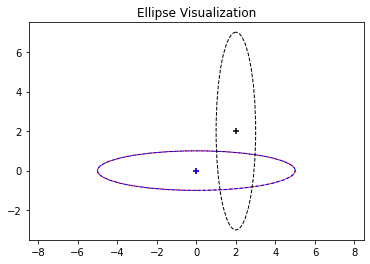


---
Comparison of Distances:

Distance: Red   - Blue 
	Gauss-Wasserstein  : 0.000
	Euclidean Distance : 5.871
Distance: Red   - Black
	Gauss-Wasserstein  : 5.902
	Euclidean Distance : 7.062
Distance: Blue  - Black
	Gauss-Wasserstein  : 5.902
	Euclidean Distance : 3.235


In [4]:
# ellipse 1 as described in eq. (33)
m1 = [0, 0]
p1 = [0, 5, 1]

# ellipse 2 as described in eq. (34)
m2 = [0, 0]
p2 = [np.pi/2, 1, 5]

# ellipse 3 (shifted center, rotated)
m3 = [2, 2]
p3 = [np.pi, 1, 5]

# ---
# show the ellipses and print the distances between them

ellipses = [(m1, p1), (m2, p2), (m3, p3)]
colors = ['red', 'blue', 'black']
linestyle = '--'

for e, c in zip(ellipses, colors):
    plot_extent(*e, col=c, style=linestyle, with_center=True)
plt.title("Ellipse Visualization")
plt.gca().axis('equal')
print("Note that the red and blue ellipse overlap exactly!")
plt.show()

print("\n---\nComparison of Distances:\n")
for i in range(len(ellipses)):
    for j in range(i+1, len(ellipses)):
        gw = gwd(ellipses[i][0], ellipses[i][1], ellipses[j][0], ellipses[j][1])
        gw = gw ** 0.5  # gwd returns squared distances
        euc = squared_euclid(ellipses[i][0], ellipses[i][1], ellipses[j][0], ellipses[j][1])
        euc = euc ** 0.5  # squared_euclid -> euclidean
        
        print("Distance: {:{f}} - {:{f}}".format(colors[i].capitalize(), colors[j].capitalize(), f=max([len(x) for x in colors])))
        print("\tGauss-Wasserstein  : {:.3f}".format(gw))
        print("\tEuclidean Distance : {:.3f}".format(euc))

As expected, the (squared) euclidean distance between the red and blue ellipse, which are identical, is non-zero. The Gauss-Wasserstein distance yields the intuitive result of 0.

Furthermore, the euclidean distances between the red and blue ellipses and the black one vary widely. Again, the Gauss-Wasserstein distance yields the intuitive result, namely that the distances between both red or blue and black are identical.

---

## Impact of Parameter Changes on Metrics

The following cells show how the GW and Euclidean Distances behave when a single parameter changes while all other ones are fixed.

Three scenarios are covered: First, only the orientation changes from no difference to $\pi$. Note that this means that the ellipses will be identical not only in the beginning, but also at the end. 

In the second scenario, the center is being moved while the shape parameters remain constant. 

Finally, the third scenario covers a sligthly different case. Here, in the beginning, the two ellipses differ in axis length and orientation. The length of the smaller ellipse is then increased over time.

In [5]:
%matplotlib inline
keys = ["angle", "center", "axis-length"]
# hyperparameters determining the maximum change of specific parameters:
max_dists = {"angle": np.pi,
             "center": 3,
             "axis-length": 4}
n_frames = 100  # number of frames in animation
color_euclid = 'orange'
color_gw = 'blue'

# set up initial locations
vals = {}
vals["angle"] = {"m": [0, 0],
                 "p": [0, 2, 1]}
vals["center"] = {"m": [0, 0],
                  "p": [0, 1, 2]}
vals["axis-length"] = {"m": [0, 0],
                "p": [0, 1, 2]}
# alt. start for the "axis-length" scenario:
vals["axis-alt"] = {"m": [0, 0],
                    "p": [np.pi/4, 0.1, 1.3]}

# arrays for changes on specific parameters
changes = {}
changes["angle"] = np.linspace(0, max_dists["angle"], num=n_frames, endpoint=True)  # values added to angle 
changes["center"] = np.linspace(0, max_dists["center"], num=n_frames, endpoint=True)  # values added to center coordinates
changes["axis-length"] = np.linspace(0, max_dists["axis-length"], num=n_frames, endpoint=True)  # values added to center coordinates

# prepare arrays for distance plots
dists = {"angle":{"euclid":[], "gw": []}, 
         "center":{"euclid":[], "gw": []},
         "axis-length":{"euclid":[], "gw": []}
        }

# set up visuals
fig, axs = plt.subplots(2,3, figsize=(15, 10))
axd = {}  # dict of axis (access axis via key)
for i, a in enumerate(axs.T):
    axd[keys[i]] = a

change_e = {}  # ellipses to change
for key in keys:
    a, l1, l2 = vals[key]["p"]
    e_fix = patches.Ellipse(xy = vals[key]["m"], width=2*l1, height=2*l2, angle=np.rad2deg(a), fill=False, color='k')
    axd[key][0].add_patch(e_fix)
    vkey = key if key != "axis-length" else "axis-alt"  # "virtual key" for alt. start in axis change scenario
    a, l1, l2 = vals[vkey]["p"]  # update shape parameters 
    change_e[key] = patches.Ellipse(xy = vals[vkey]["m"], width=2*l1, height=2*l2, angle=np.rad2deg(a), fill=False, color='orange', linestyle='--')
    axd[key][0].add_patch(change_e[key])
    # --- graph format
    axd[key][0].set_xlim(-5, 5)
    axd[key][0].set_ylim(-5, 5)
    axd[key][1].set_xlim(0, max_dists[key])
    axd[key][1].set_ylim(0, 5)
    axd[key][1].set_xlabel("Change in parameter")
    axd[key][1].set_ylabel("Distance")
    axd[key][0].set_title("Changing {}".format(key))

plt.suptitle("Distance changes when changing single parameters")
fig.tight_layout()

graphs = {}
for key in keys:
    graphs[key] = {}
    graphs[key]["euclid"], = axd[key][1].plot([], [], label="Euclidean", c=color_euclid)
    graphs[key]["gw"], = axd[key][1].plot([], [], label="GW", c=color_gw)
    axd[key][1].legend(loc='upper left')
    
# --- animation code
def draw_frame(n):
    if n==0:
        # only update on first "real" frame to prevent dim errors
        return []
    used_objects = []
    change_e["angle"]._angle = np.rad2deg(vals["angle"]["p"][0] + changes["angle"][n])
    used_objects.append(change_e["angle"])
    change_e["center"].set_center(np.array(vals["center"]["m"])+changes["center"][n])
    used_objects.append(change_e["center"])
    change_e["axis-length"]._width = 2 * (vals["axis-alt"]["p"][1] + changes["axis-length"][n])  # double: convert semi-axis length to full length
    used_objects.append(change_e["axis-length"])
    
    for key in keys:
        m1 = change_e[key].get_center()
        p1 = [np.deg2rad(change_e[key]._angle), change_e[key]._width * 0.5, change_e[key]._height * 0.5]  # mpl stores full not semi-axis length
        m2 = vals[key]["m"]
        p2 = vals[key]["p"]
        sgw = gwd(m1, p1, m2, p2)  # squared gw
        dists[key]["gw"].append(sgw**0.5)
        se = squared_euclid(m1, p1, m2, p2)  # squared euclidean
        dists[key]["euclid"].append(se**0.5)
        # x = changes[key][:len(dists[key]["euclid"])]
        graphs[key]["euclid"].set_data(changes[key][:len(dists[key]["euclid"])], dists[key]["euclid"])
        graphs[key]["gw"].set_data(changes[key][:len(dists[key]["gw"])], dists[key]["gw"])
    return used_objects

plt.close()  # ensure nothing is showing up
anim = animation.FuncAnimation(fig, draw_frame, frames=n_frames, interval=100, blit=True)
anim